In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
using Random

In [6]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

  2.471705 seconds (13.17 M allocations: 561.730 MiB, 5.15% gc time)


In [9]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.5*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.058592 seconds (9.51 M allocations: 553.516 MiB, 4.72% gc time)


-1.104418600678453

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

  2.476882 seconds (16.84 M allocations: 824.252 MiB, 6.36% gc time)


In [11]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.681237 seconds (2.45 M allocations: 141.423 MiB, 6.02% gc time)


-0.22434319174055029

In [12]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.5*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    uϵ = -uϵ
end
λϵ

-1.250805205353589

In [13]:
λ₀ + ϵ*λ_dot

-1.2165901965487282

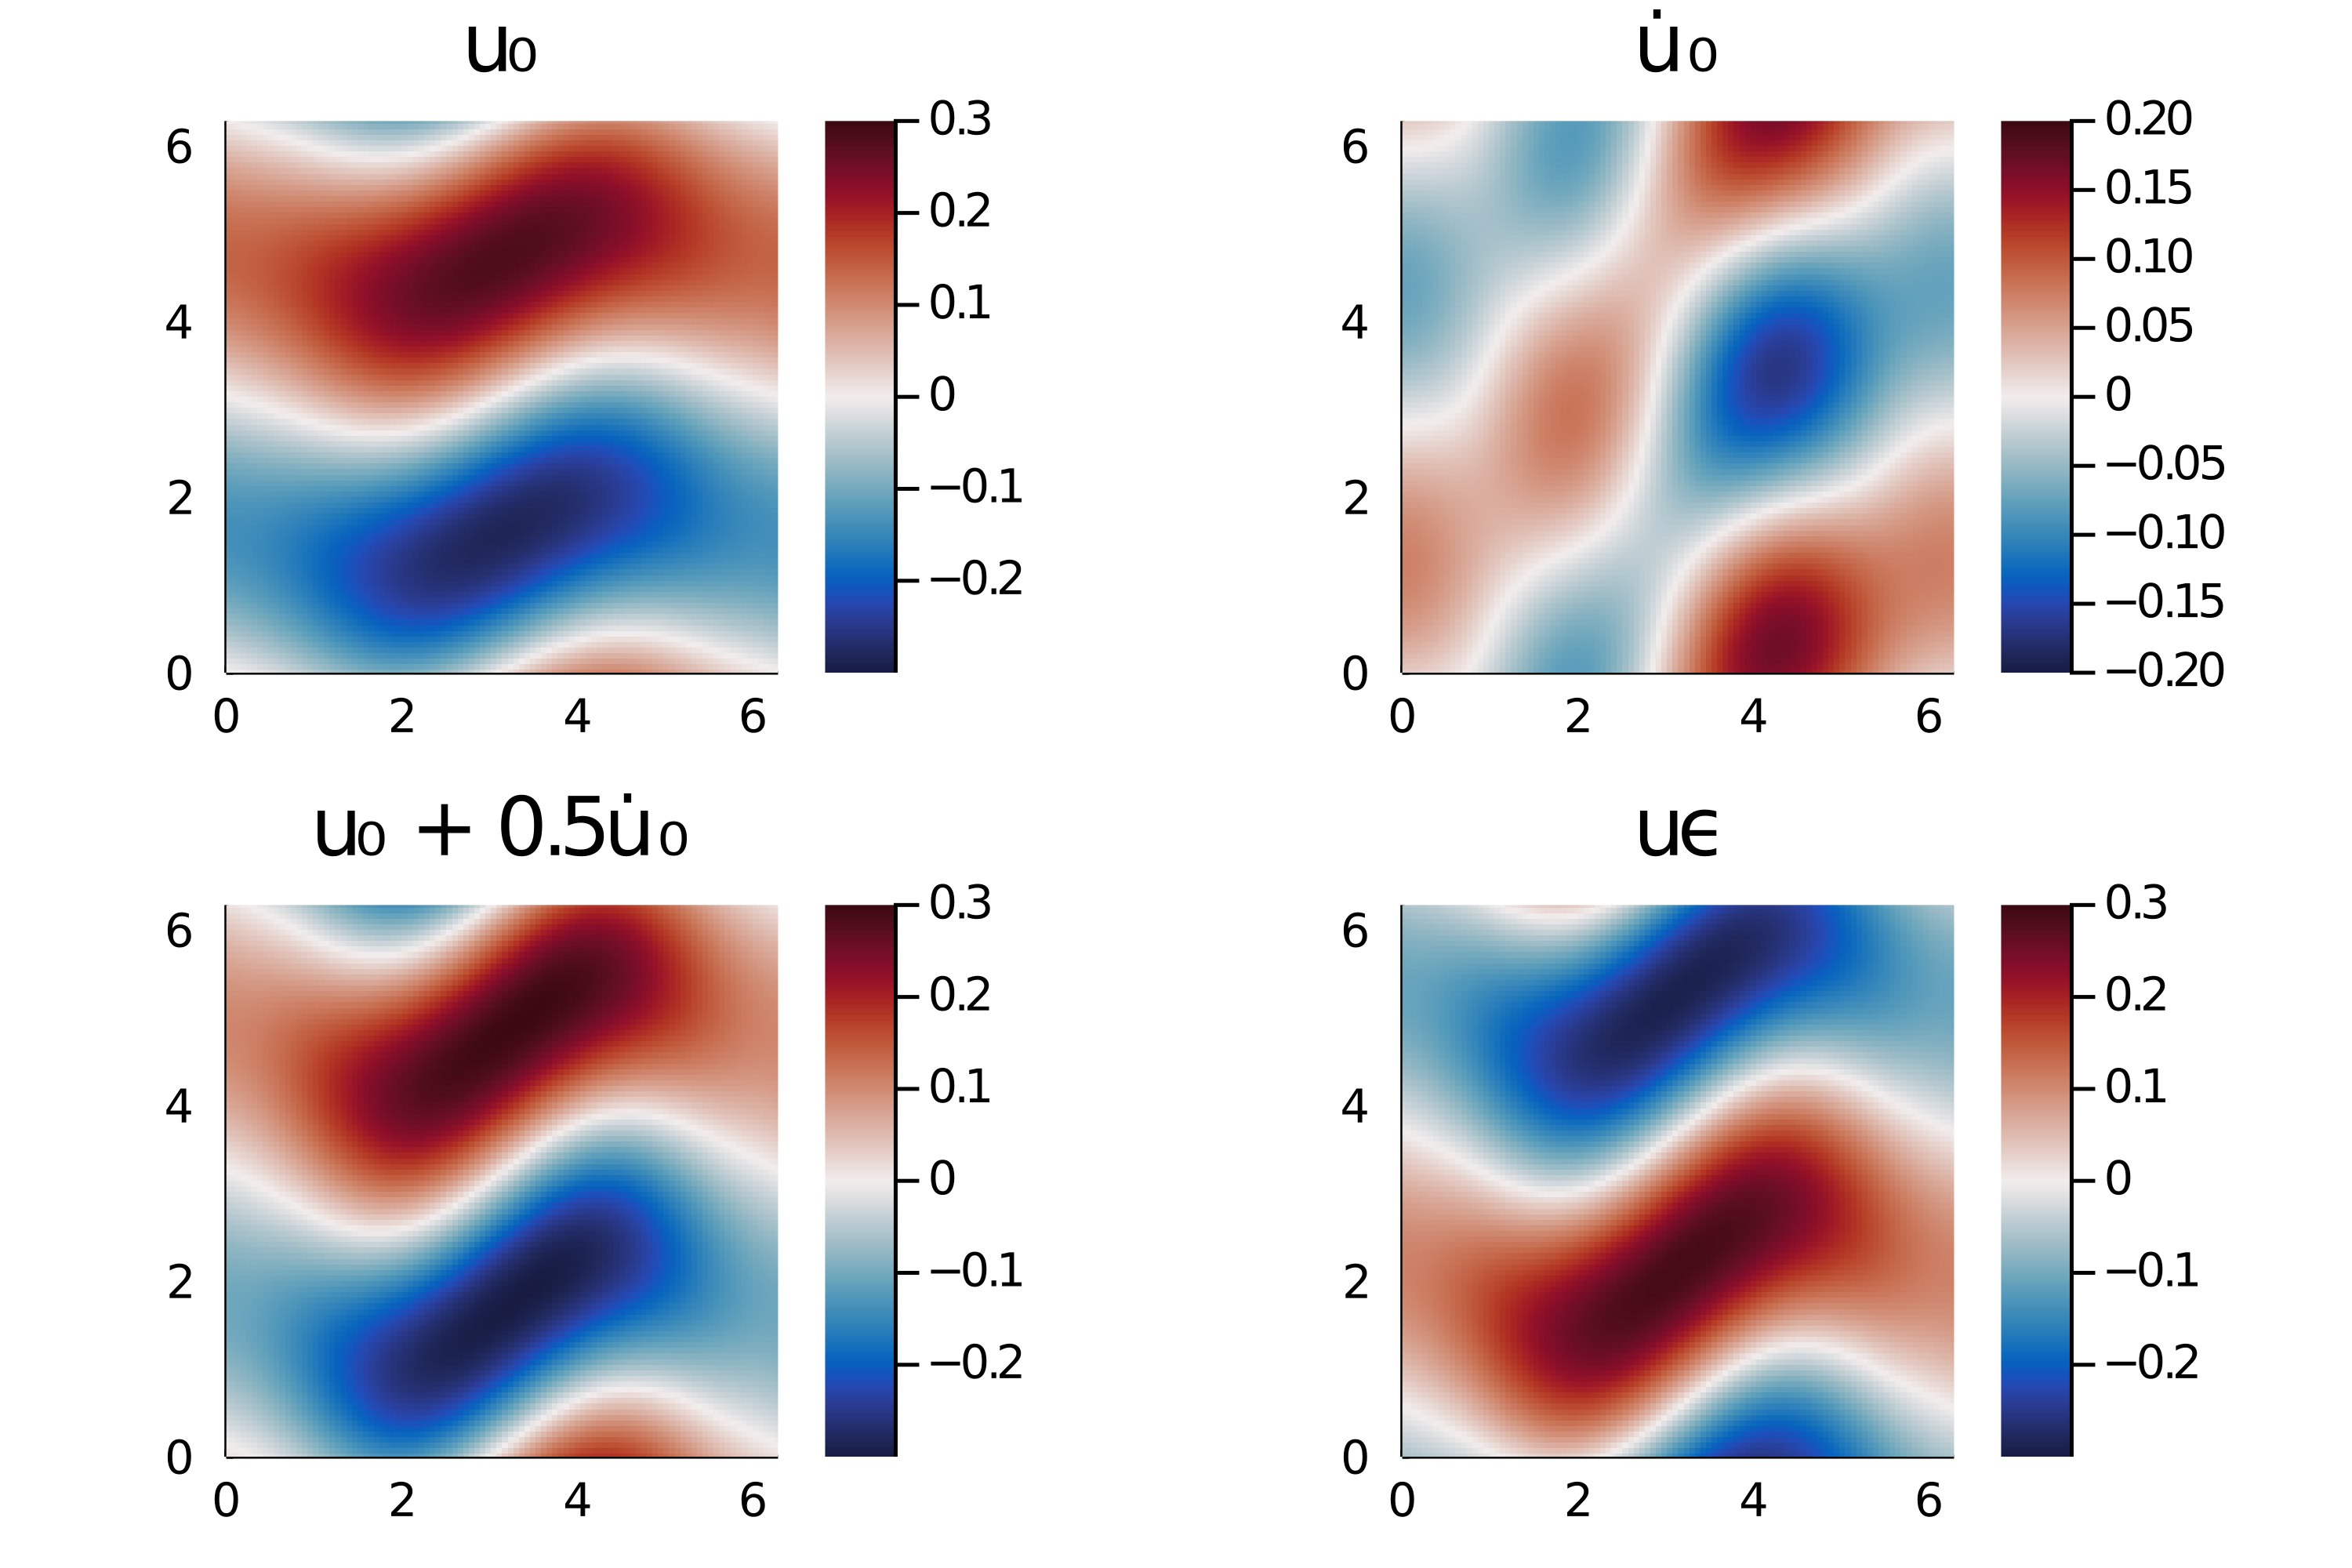

In [14]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [15]:
using StaticArrays
using Contour

In [16]:
#only works for 2D
function apply2curve(flowmap, curve::Curve2{T}) where {T}
    moved_points = [SVector{2,Float64}(flowmap(x)) for x in zip(coordinates(curve)...)]
    return Curve2(moved_points)   
end

apply2curve (generic function with 1 method)

In [17]:
function getLength(curve, tensorfield=(x,y) -> 1)
    xs, ys = coordinates(curve)
    n = length(xs)
    result = 0
    for j in 1:(n-1)
        current_x, current_y   = xs[j], ys[j]
        next_x, next_y         = xs[j+1], ys[j+1]
        approxTangentVector = [next_x - current_x, next_y - current_y]
        result += sqrt(approxTangentVector ⋅ (tensorfield(curx, cury) * approxTangentVector))
    end
    return result
end

getLength (generic function with 2 methods)

In [18]:
# from contour.jl we only get the guarantee that either the first and last points are equal, or the contour starts and
# ends at the boundary of Ω. in the last case, we will have to construct a closed curve e.g. in order to determine the
# enclosed area
function closeCurve(ctx,curve::Curve2{T};tolerance=0.0,orientation=:clockwise) where {T}
    xs, ys = coordinates(curve)
    start_x, start_y, end_x, end_y = xs[1], ys[1], xs[end], ys[end]
    
    if (start_x == end_x && start_y == end_y)
        return curve
    end  
    
    points = [SA[x,y] for (x,y) in zip(xs,ys)]

    LL, UR = ctx.spatialBounds
    #Curve2 wants StaticArrays
    LL, UR = SA[LL[1], LL[2]], SA[UR[1], UR[2]]
    LR, UL = SA[UR[1], LL[2]], SA[LL[1], UR[2]] 
    
    # We have a rectangle, and order its sides like
    #     3                         3
    #    --                        --
    #  2|  |4  for clockwise,    4|  |2 for anticlockwise orientation.
    #    --                        --
    #     1                         1
    #
    # corners[i] then is the next corner in the respective orientation.
    
    if orientation==:clockwise
        corners = [LL, UL, UR, LR]
    elseif orientation ==:anticlockwise
        corners = [LR, UR, UL, LL]
    else
        error("Unknown orientation '",orientation,"'!")
    end
    
    if     abs(end_y-corners[1][2])<=tolerance
        side = 1
    elseif abs(end_x-corners[2][1])<=tolerance
        side = 2
    elseif abs(end_y-corners[3][2])<=tolerance
        side = 3
    elseif abs(end_x-corners[4][1])<=tolerance
        side = 4
    else                              # point does not lie on the boundary
        error("A curve has either to be closed or start and end at the boundary!")
    end
    
    i = 0
    while(abs(start_x-end_x)>tolerance && abs(start_y-end_y)>tolerance)
        push!(points,corners[side])
        end_x = corners[side][1]
        end_y = corners[side][2]
        side = (side%4)+1
        i += 1
        if i>4  # might happen if the first point is not on the border, prevent infinite loops
            error("A curve has either to be closed or start and end at the boundary!")
        end
    end
    push!(points,points[1])  # close curve
    return Curve2(points)
end

closeCurve (generic function with 1 method)

In [19]:
# If the first point is not the last point, we might get vol(Ω)-area instead
function getEuclideanArea(ctx,curve;tolerance=0.0)
    
    curve = closeCurve(ctx,curve,tolerance=tolerance)
        
    xs, ys = coordinates(curve)
    center_x, center_y = mean(xs), mean(ys)
    n = length(xs)
    result = 0.0
    for j in 1:(n-1)
        current_x, current_y   = xs[j], ys[j]
        next_x, next_y         = xs[j+1], ys[j+1]

        x1 = current_x - center_x
        x2 = next_x - center_x
        y1 = current_y - center_y
        y2 = next_y - center_y
        
        area = 0.5*det([x2 y2; x1 y1])
        result +=area
    end
    return abs(result)
end

getEuclideanArea (generic function with 1 method)

In [20]:
function dynamic_cheeger_value(ctx, curve, flowmap; tolerance=0.0)
    LL, UR = ctx.spatialBounds
    volume_Ω = (UR[1] - LL[1]) * (UR[2] - LL[2])
    curve_closed_cw  = closeCurve(ctx,curve,tolerance=tolerance,orientation=:clockwise)
    image_curve_cw   = apply2curve(flowmap,curve_closed_cw)
    curve_closed_acw = closeCurve(ctx,curve,tolerance=tolerance,orientation=:anticlockwise)
    image_curve_acw  = apply2curve(flowmap,curve_closed_acw)
    combined_length  = min(getLength(curve_closed_cw)  + getLength(image_curve_cw),
                           getLength(curve_closed_acw) + getLength(image_curve_acw))
    volume_curve = getEuclideanArea(ctx,curve,tolerance=tolerance)
    return 0.5 * combined_length / min(volume_curve, (volume_Ω - volume_curve))
end

dynamic_cheeger_value (generic function with 1 method)

In [21]:
function get_levelset(ctx, u, c;
        x_resolution=nothing, y_resolution=nothing, n_candidates=10, bdata=BoundaryData())
    
    if x_resolution==nothing
        x_resolution = ctx.numberOfPointsInEachDirection[1]
    end
    if y_resolution==nothing
        y_resolution = ctx.numberOfPointsInEachDirection[2]
    end
    
    xs = range(ctx.spatialBounds[1][1], stop=ctx.spatialBounds[2][1], length=x_resolution)
    ys = range(ctx.spatialBounds[1][2], stop=ctx.spatialBounds[2][2], length=y_resolution)
    u_dofvals = undoBCS(ctx, u, bdata)
    u_nodevals = u_dofvals[ctx.node_to_dof]

    fs = [evaluate_function_from_node_or_cellvals(ctx, u_nodevals, Vec{2}((x,y)))
        for x in xs, y in ys]
    
    return Contour.contour(xs,ys,fs,c)
    
end

get_levelset (generic function with 1 method)

In [22]:
function get_minimal_levelset(ctx, u, objective_function; 
        x_resolution=nothing, y_resolution=nothing, n_candidates=100, bdata=BoundaryData())
    
    if x_resolution==nothing
        x_resolution = ctx.numberOfPointsInEachDirection[1]
    end
    if y_resolution==nothing
        y_resolution = ctx.numberOfPointsInEachDirection[2]
    end
    
    xs = range(ctx.spatialBounds[1][1], stop=ctx.spatialBounds[2][1], length=x_resolution)
    ys = range(ctx.spatialBounds[1][2], stop=ctx.spatialBounds[2][2], length=y_resolution)

    u_dofvals = undoBCS(ctx, u, bdata)
    u_nodevals = u_dofvals[ctx.node_to_dof]

    fs = [evaluate_function_from_node_or_cellvals(ctx, u_nodevals, Vec{2}((x,y)))
        for x in xs, y in ys]

    currentmin = Inf
    result = nothing
    
    for cl in levels(contours(xs, ys, fs, n_candidates))
        value = objective_function(cl)
        if value < currentmin
            currentmin = value
            result = cl
        end
    end
    return result, currentmin
end

get_minimal_levelset (generic function with 1 method)

In [23]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

dynamic_cheeger_value_levelset (generic function with 1 method)

In [24]:
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

dynamic_cheeger_value_levelset_nonnegative (generic function with 1 method)

In [25]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00028475029668045826
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0008542308768763607
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.001423711457072263
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0019931920372681655
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.002562672617464068
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0031321531976599704
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0037016337778558728
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004271114358051775
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004840594938247678
└ @ Main In[24]:7
┌ Warning: Currently o

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05267696367470365
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05324644425489955
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05381592483509545
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.054385405415291355
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05495488599548726
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05552436657568316
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05609384715587906
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.056663327736074964
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05723280831627087
└ @ Main In[24]:7
┌ Warning: Currently only connected

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10563865763292274
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10620813821311864
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10677761879331454
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10734709937351045
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10791657995370635
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10848606053390225
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10905554111409815
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10962502169429406
└ @ Main In[24]:7
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.11019450227448996
└ @ Main In[24]:7
┌ Warning: Currently only connected l

Dynamic Cheeger value:	1.7431895668263537
Levelset:		0.1967555504642674


2.0741040122475933	13.143429070085375	24.80440651443279	9.148006888862861
1.7431895668263537	9.449895504106129	8.318021848911668	5.0963812803693


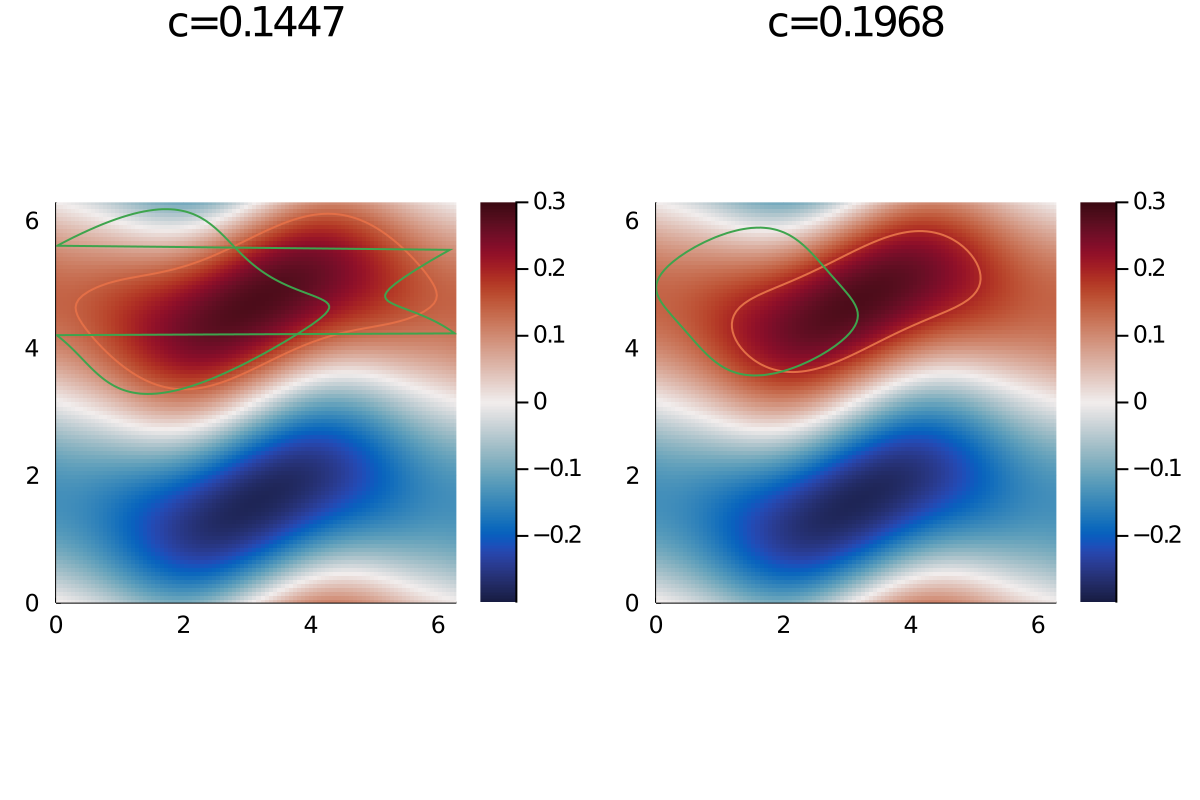

In [26]:
#value from paper
c = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c, bdata=bdata))[1]
curve_moved = apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("$(cheeger_value)\t$(getLength(curve))\t$(getLength(curve_moved))\t$(getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


c = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c, bdata=bdata))[1]
curve = closeCurve(ctx,curve)
curve_moved = apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("$(cheeger_value)\t$(getLength(curve))\t$(getLength(curve_moved))\t$(getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot(plot_paper, plot_ours, fmt=:png,dpi=200)